In [1]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import librosa
import time
import matplotlib.pyplot as plt
import copy
import os
from tqdm import tqdm

In [2]:
# dataset downoloading
#!gdown --id 1pZ7YYCNPUhjlj2aKX24gNlhxZ3ctx6k1

In [3]:
# !tar -xvf cv-corpus-7.0-2021-07-21-ru.tar.gz

In [ ]:
# не обязательно устанавливать speechbrain, так как не стал применять

In [2]:
# !pip install speechbrain

In [3]:
# !git clone https://github.com/speechbrain/speechbrain.git

In [4]:
# %cd speechbrain

In [5]:
# !pip install packaging==20.9
# !pip install zipp==3.1.0
# !pip install filelock==3.2

In [6]:
# %pip install -r requirements.txt

In [7]:
# pip install --editable .

In [8]:
# import speechbrain as sb

In [20]:
# %cd ..

/workspace/raid/data/dkorzh/TERM 7/TinkSpeech


# Data preproccessing

In [4]:
import pandas as pd

df_train = pd.read_csv('./cv-corpus-7.0-2021-07-21/ru/train.tsv', sep='\t')
df_test = pd.read_csv('./cv-corpus-7.0-2021-07-21/ru/test.tsv', sep='\t')
df_train.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949650.mp3,Теперь слово предоставляется Генеральному секр...,2,0,teens,male,NaN,ru,NaN
1,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949651.mp3,"В португальском языке такие слова, как жизнь, ...",2,0,teens,male,NaN,ru,NaN
2,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949693.mp3,За прошедший год значительно продвинулось суде...,2,0,teens,male,NaN,ru,NaN
3,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949699.mp3,Я предоставляю слово наблюдателю от Святого Пр...,2,0,teens,male,NaN,ru,NaN
4,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949704.mp3,Швейцария стала одним из ее авторов.,2,0,teens,male,NaN,ru,NaN


In [5]:
df_train = df_train[['client_id','path','gender']]

In [6]:
df_train.head()

,client_id,path,gender
0,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949650.mp3,male
1,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949651.mp3,male
2,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949693.mp3,male
3,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949699.mp3,male
4,119124394354a868c8f5bc2b09616c27f7521a639b06bd...,common_voice_ru_21949704.mp3,male


In [7]:
df_train.isna().sum()

client_id       0
path            0
gender       1372
dtype: int64

In [8]:
df_train.shape

(17070, 3)

In [9]:
df_train.gender.value_counts()

male      13074
female     2556
other        68
Name: gender, dtype: int64

**Есть заметный imbalance по gender-- возьмем все женские записи и 3000 рандомных мужских**

In [10]:
len(df_train.client_id.unique())

117

**всего 117 спикеров**

In [11]:
df_test = df_test[['client_id','path','gender']]
df_test.isna().sum()

client_id       0
path            0
gender       4572
dtype: int64

In [12]:
df_test.shape

(8425, 3)

In [13]:
df_test.gender.value_counts()


male      3185
female     668
Name: gender, dtype: int64

In [14]:
a = set(df_train.client_id.unique())
len(a)


117

In [15]:
b = set(df_test.client_id.unique())
len(b)


1202

**вот это хорошо, что много разных людей говорили в тесте**

**делаем итоговые датасеты**

In [16]:
df_train_female = df_train[df_train.gender=='female'].copy()
df_train_female.head()

,client_id,path,gender
306,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22685925.mp3,female
307,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22685955.mp3,female
308,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22685956.mp3,female
309,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22686010.mp3,female
310,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22686014.mp3,female


In [17]:
df_train_male = df_train[df_train.gender=='male'].sample(3000).copy()
df_train_male.shape

(3000, 3)

In [18]:
df_train = df_train_female.append(df_train_male)
df_train.shape

(5556, 3)

In [19]:
df_train = df_train.sample(frac=1)
df_train.head()

,client_id,path,gender
11152,bd4b753eeeedcc84cea162e32dd4fd94e4f52d5acdd5d2...,common_voice_ru_20838501.mp3,male
1287,b020a737f6071a746fbb5f85f3eec369ffb315bb66b625...,common_voice_ru_22161098.mp3,male
316,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22686115.mp3,female
333,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22704060.mp3,female
13817,299f0dd85f2861f679e92991dc15e9adbdcc7cb8ce7e6d...,common_voice_ru_18858660.mp3,male


In [27]:
df_train.isna().sum()

client_id    0
path         0
gender       0
dtype: int64

In [20]:
df_train = df_train.reset_index(drop=True)
df_train.head()

,client_id,path,gender
0,bd4b753eeeedcc84cea162e32dd4fd94e4f52d5acdd5d2...,common_voice_ru_20838501.mp3,male
1,b020a737f6071a746fbb5f85f3eec369ffb315bb66b625...,common_voice_ru_22161098.mp3,male
2,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22686115.mp3,female
3,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22704060.mp3,female
4,299f0dd85f2861f679e92991dc15e9adbdcc7cb8ce7e6d...,common_voice_ru_18858660.mp3,male


In [21]:
df_train['gender'].replace(to_replace=['female', 'male'],value= [0, 1], inplace=True)
df_train.head()

,client_id,path,gender
0,bd4b753eeeedcc84cea162e32dd4fd94e4f52d5acdd5d2...,common_voice_ru_20838501.mp3,1
1,b020a737f6071a746fbb5f85f3eec369ffb315bb66b625...,common_voice_ru_22161098.mp3,1
2,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22686115.mp3,0
3,bd7753ba89f42386c225ef69644e8dd39abba1f9aa3d57...,common_voice_ru_22704060.mp3,0
4,299f0dd85f2861f679e92991dc15e9adbdcc7cb8ce7e6d...,common_voice_ru_18858660.mp3,1


In [22]:
df_test = df_test.dropna()

In [23]:
df_test['gender'].replace(to_replace=['female', 'male'],value= [0, 1], inplace=True)
df_test.shape

(3853, 3)

In [24]:
df_train.to_csv('train_preproc_balanced.csv')

In [25]:
df_test.to_csv('test_dropna.csv')

**Перегоним mp3 в np.arrays и сделаем даталоадеры**

In [26]:
!nvidia-smi

Sun Jan  9 15:05:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    56W / 300W |   7621MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:
df = pd.read_csv('train_preproc_balanced.csv')

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
label_encoder = LabelEncoder()
train_label_ids_gender = label_encoder.fit_transform(df.gender)

labels_train_gender = torch.LongTensor(train_label_ids_gender)

all_dataset = list(zip(df.path,labels_train_gender))

train_files, val_files = train_test_split(all_dataset, test_size=0.25)

In [6]:
ls

ADDITIONAL_TASK_BEST.pt             example_not_norm.npy
VoiceGenderClf.ipynb                speechbrain/
audio_npy/                          test_dropna.csv
cv-corpus-7.0-2021-07-21/           train_preproc_balanced.csv
cv-corpus-7.0-2021-07-21-ru.tar.gz


In [7]:
path = "cv-corpus-7.0-2021-07-21/ru/clips/"

In [8]:
train_files[0][0]

'common_voice_ru_18892705.mp3'

In [9]:
# # !pip install soundfile
# !pip install sndfile
# !pip install ffmpeg
# !pip install ffprobe

In [10]:
import pydub 
import numpy as np

def read(f, normalized=False, sr=16000):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    a = a.set_frame_rate(sr)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

In [24]:
# !apt-get update
# apt-get install ffmpeg

In [11]:
sr, x = read(path+'common_voice_ru_20656895.mp3')

In [12]:
np.save('example_not_norm.npy', x)

In [13]:
from IPython.display import Audio 
Audio(path+'common_voice_ru_20656895.mp3', autoplay=True)

In [14]:
sr

16000

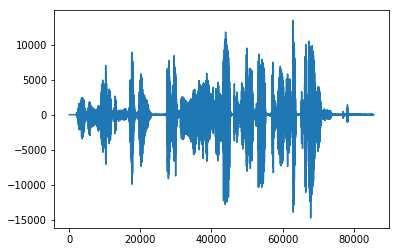

In [15]:
plt.plot(x)

In [16]:
y = np.fft.fft(x)

/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


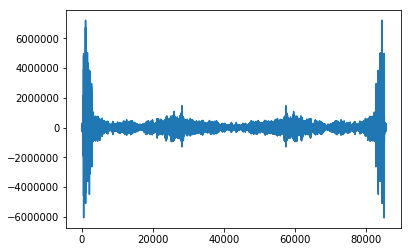

In [17]:
plt.plot(y)

In [18]:
# ls "cv-corpus-7.0-2021-07-21/ru/clips/"

In [20]:
a = os.listdir("./cv-corpus-7.0-2021-07-21/ru/clips/")

In [21]:
len(a)
#довольно много, поэтому будем переводить в нампай только отобранные

115988

**начнем перегон mp3 в numpy arrays. единственное, есть смысл сделать аудио одинаковой длины, обрезав или западив**

In [24]:
DIR_TO_SAVE = 'audio_npy/'

In [63]:
# %mkdir audio_npy

In [62]:
df.head()

,Unnamed: 0,client_id,path,gender
0,0,5e949643688ea0d3800197ff7d1c8afe7936cffbcee3a0...,common_voice_ru_18892576.mp3,0
1,1,237823cbf2c238371c07276002cf9731316ac0f11c6528...,common_voice_ru_19091861.mp3,1
2,2,299f0dd85f2861f679e92991dc15e9adbdcc7cb8ce7e6d...,common_voice_ru_18864494.mp3,1
3,3,e134f72e7ee1e4a3bc648a8ff25da594867d8b03d3e57e...,common_voice_ru_25405041.mp3,1
4,4,560d9b4832633ea25c9ae33aad194caeae7050194cd4e6...,common_voice_ru_18898619.mp3,1


In [93]:
sr, x = read(path+'common_voice_ru_20656895.mp3')

In [94]:
len(x)

85632

In [100]:
x = np.ones(77776)

In [103]:
def padder(x, sr=16000, t=5):
    npy_len = t*sr
    if len(x)>npy_len:
        q=len(x)-npy_len
        x = x[q//2:q//2+npy_len]
    elif len(x)<npy_len:
        x = np.pad(x,(0, npy_len), mode='symmetric')[:npy_len]
    return x

x1 = padder(x)
len(x1)

80000

In [88]:
x1

array([-1635, -1441, -1272, -1151, -1065,  -962,  -808,  -666,  -493,
        -340,  -192,   -91,     3,   160,   342,   508,   668,   793,
         904,  1013,  1103,  1199,  1291,  1342], dtype=int16)

In [105]:
# path = "cv-corpus-7.0-2021-07-21/ru/clips/"
# from tqdm import tqdm
# for n in tqdm(df.path):
#     name = path+n
#     path_to_save = DIR_TO_SAVE+n[:-4]+'_padded.npy'
#     sr, x = read(name, normalized=True, sr=16000)
#     x = padder(x, sr=sr, t=5)
#     #print(len(x))
#     #print(len(x))
#     np.save(path_to_save, x)

100%|██████████| 5556/5556 [13:46<00:00,  6.72it/s]


In [22]:
df_test = pd.read_csv('test_dropna.csv')

In [107]:
# path = "cv-corpus-7.0-2021-07-21/ru/clips/"
# from tqdm import tqdm
# for n in tqdm(df_test.path):
#     name = path+n
#     path_to_save = DIR_TO_SAVE+n[:-4]+'_padded.npy'
#     sr, x = read(name, normalized=True, sr=16000)
#     x = padder(x, sr=sr, t=5)
#     #print(len(x))
#     #print(len(x))
#     np.save(path_to_save, x)

100%|██████████| 3853/3853 [09:40<00:00,  6.63it/s]


In [25]:
DIR_TO_SAVE = 'audio_npy/'
def collate_batch(batch, path = DIR_TO_SAVE):
    arr = []

    labels_gender = torch.LongTensor([label for _,label in batch])   
    
    for train_path in batch:
        arr.append(np.load(path + train_path[0][:-4]+'_padded.npy'))
     # print(arr[-1].shape)
     
    arr_pad = torch.Tensor(arr).to(device)

    return [arr_pad, labels_gender]  

In [26]:
train_dataloader = DataLoader(train_files, batch_size=64, shuffle=True, 
                                  collate_fn=collate_batch)

val_dataloader = DataLoader(val_files, batch_size=64, shuffle=False, 
                              collate_fn=collate_batch)

In [27]:
l = 

In [64]:
l.shape

AttributeError: 'list' object has no attribute 'shape'

In [30]:
len(l[0])

64

In [58]:
l[0][0].shape

torch.Size([80000])

# Super stupid baseline: FFNN or even Logreg

In [39]:
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(80000, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [38]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, savename='ADDITIONAL_TASK_BEST', is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

#                     if is_inception and phase == 'train':
#                         # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
#                         outputs, aux_outputs = model(inputs)
#                         loss1 = criterion(outputs, labels)
#                         loss2 = criterion(aux_outputs, labels)
#                         loss = loss1 + 0.4*loss2
#                     else:
#                         outputs = model(inputs)
#                         loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), savename+'.pt')
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [33]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [40]:
model = FFNN()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.90) #, weight_decay=0.0001
criterion = nn.CrossEntropyLoss()

In [41]:
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, savename='FFNN_baseline')
# в общеи, такая модель переобучается, потому что парметров больше, чем входных данных

Epoch 0/9
----------


100%|██████████| 66/66 [01:18<00:00,  1.19s/it]


train Loss: 0.6890 Acc: 0.5455


100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


val Loss: 0.6941 Acc: 0.5234

Epoch 1/9
----------


100%|██████████| 66/66 [01:17<00:00,  1.18s/it]


train Loss: 0.6652 Acc: 0.5498


100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


val Loss: 0.6896 Acc: 0.5241

Epoch 2/9
----------


100%|██████████| 66/66 [01:17<00:00,  1.17s/it]


train Loss: 0.5725 Acc: 0.7670


100%|██████████| 22/22 [00:25<00:00,  1.14s/it]


val Loss: 0.6868 Acc: 0.5472

Epoch 3/9
----------


100%|██████████| 66/66 [01:18<00:00,  1.19s/it]


train Loss: 0.3026 Acc: 0.9148


100%|██████████| 22/22 [00:25<00:00,  1.14s/it]


val Loss: 0.8257 Acc: 0.5587

Epoch 4/9
----------


100%|██████████| 66/66 [01:16<00:00,  1.15s/it]


train Loss: 0.1133 Acc: 0.9674


100%|██████████| 22/22 [00:24<00:00,  1.13s/it]


val Loss: 1.0891 Acc: 0.5803

Epoch 5/9
----------


100%|██████████| 66/66 [01:16<00:00,  1.15s/it]


train Loss: 0.0443 Acc: 0.9947


100%|██████████| 22/22 [00:24<00:00,  1.13s/it]


val Loss: 1.2634 Acc: 0.5666

Epoch 6/9
----------


100%|██████████| 66/66 [01:16<00:00,  1.16s/it]


train Loss: 0.0197 Acc: 0.9993


100%|██████████| 22/22 [00:24<00:00,  1.13s/it]


val Loss: 1.4005 Acc: 0.5630

Epoch 7/9
----------


 11%|█         | 7/66 [00:09<01:19,  1.35s/it]


KeyboardInterrupt: 

# Попробуем модель со свертками - тоже не работает на чистых данных

In [99]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 3, kernel_size= 500, stride=100)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(3, 3, kernel_size=100, stride = 20)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(105, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        #x = self.flatten(x)
        #x = x[:,None,:]
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        
        x = self.flatten(x)
        
        #print(x.shape)
        logits = self.linear_relu_stack(x)
        return logits

In [103]:
DIR_TO_SAVE = 'audio_npy/'
def collate_batch(batch, path = DIR_TO_SAVE):
    arr = []

    labels_gender = torch.LongTensor([label for _,label in batch])   
    
    for train_path in batch:
        arr.append(np.load(path + train_path[0][:-4]+'_padded.npy'))
     # print(arr[-1].shape)
     
    arr_pad = torch.Tensor(arr).to(device)
    arr_pad = arr_pad[:, None, :]
    return [arr_pad, labels_gender]  

train_dataloader = DataLoader(train_files, batch_size=128, shuffle=True, 
                                  collate_fn=collate_batch)

val_dataloader = DataLoader(val_files, batch_size=128, shuffle=False, 
                              collate_fn=collate_batch)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [106]:
model = ConvNN()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6) #, weight_decay=0.0001
criterion = nn.CrossEntropyLoss()

In [107]:
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, savename='Conv_baseline')
# в общеи, такая модель переобучается, потому что парметров больше, чем входных данных

Epoch 0/9
----------


100%|██████████| 33/33 [01:16<00:00,  2.31s/it]


train Loss: 0.6919 Acc: 0.5455


100%|██████████| 11/11 [00:24<00:00,  2.25s/it]


val Loss: 0.6927 Acc: 0.5234

Epoch 1/9
----------


100%|██████████| 33/33 [01:16<00:00,  2.33s/it]


train Loss: 0.6919 Acc: 0.5455


100%|██████████| 11/11 [00:24<00:00,  2.21s/it]


val Loss: 0.6927 Acc: 0.5234

Epoch 2/9
----------


100%|██████████| 33/33 [01:15<00:00,  2.30s/it]


train Loss: 0.6919 Acc: 0.5455


100%|██████████| 11/11 [00:24<00:00,  2.23s/it]


val Loss: 0.6927 Acc: 0.5234

Epoch 3/9
----------


 36%|███▋      | 12/33 [00:30<00:52,  2.52s/it]


KeyboardInterrupt: 

# References

* https://stackoverflow.com/questions/53633177/how-to-read-a-mp3-audio-file-into-a-numpy-array-save-a-numpy-array-to-mp3
* https://towardsdatascience.com/audio-classification-with-pytorchs-ecosystem-tools-5de2b66e640c
* https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
